# Iniciando a Análise do Dataset de QR Codes

Primeiramente, vamos importar bibliotecas importantes que usaremos no projeto:

In [ ]:
import os                               # juntar paths
import pandas as pd                     # ler documento csv
from matplotlib import pyplot as plt    # plotar imagens
from matplotlib import patches          # desenhar retangulos nas imagens
from tqdm import tqdm                   # barra de progresso
from glob import glob

### Explorando o banco de dados
Agora, podemos começar lendo nosso banco de dados:

In [ ]:
df = pd.read_csv("qr_codes_all.csv")   # (depois na prox reuniao podemos separar os datasets de treino, teste e validacao)
df.head(10)

,image_id,image_height,image_width,object_id,class,xmin,ymin,xmax,ymax
0,5301073148,1936,2592,0,qr_code,562,1034,880,1336
1,4821931054,1024,681,1,qr_code,487,711,579,816
2,4021470349,999,669,2,qr_code,291,561,442,710
3,3346775330,732,1024,3,qr_code,22,661,82,722
4,3756525934,1200,1600,4,qr_code,477,595,592,752
5,3424245467,1360,2048,5,qr_code,1230,647,1706,1117
6,5164857092,576,1024,6,qr_code,52,263,83,304
7,3552874141,425,640,7,qr_code,29,78,264,312
8,4071142993,685,1024,8,qr_code,198,446,257,504
9,4328183928,2592,1944,9,qr_code,834,1188,1129,1474


Observando o documento em csv e a coluna *image_id*, é possível perceber que os nomes do documentos das imagens estão no formato: **<número de 10 digitos>.jpg** . Ou seja, se a imagem ter o *image_id* de 1, o nome do documento da imagem na pasta images é *0000000001.jpg*. Como no documento csv os *image_id's* estão sem esses zeros adicionais, vamos fazer uma função para adicionar esses zeros faltantes para lermos as imagens sem problemas:

In [ ]:
def convert_image_id(image_id: int) -> str:
	# adiciona zeros iniciais necessarios nos ids de imagens de tamanho menor que dez.
	image_id = str(image_id)
	if len(image_id) < 10:
		return ("0"*(10 - len(image_id))) + image_id
	return image_id

In [ ]:
def cria_dict(path: str)-> dict:
  df = pd.read_csv(path)
  ret={}
  for index, row in tqdm(df.iterrows()):
    xc = (row['xmax'] + row['xmin'])/(2*row['image_width'])
    yc = (row['ymax'] + row['ymin'])/(2*row['image_height'])
    wi = (row['xmax'] - row['xmin'])/(row['image_width'])
    ht = (row['ymax'] - row['ymin'])/(row['image_height'])
    id = convert_image_id(row['image_id'])
    if not (id in ret):
      ret[id]=[]
    ret[id].append({"x_center": xc, "y_center":yc, "width":wi, "height":ht})

  return ret
  


In [ ]:
def save_to_txt(data: dict, path: str) -> None:
  base_path=path + '/{}.txt'
  for (key, val) in data.items():
    path = base_path.format(key)
    with open(path, 'w') as f:
      for d in val:
        f.write(f"0 {d['x_center']} {d['y_center']} {d['width']} {d['height']}\n")
    

In [ ]:
save_to_txt(cria_dict('/content/drive/Shareddrives/ML+Vision/projeto QR Code/qr_codes/qr_codes_all.csv'), path='/content/drive/Shareddrives/ML+Vision/projeto QR Code/qr_codes/labels')

1263it [00:00, 10185.63it/s]


Então, vamos ler nosso dataset e colocar nossos dados em uma lista, para poder visualizar alguns QR Codes.

In [ ]:
image_path = "./images/"
imgs = {}
for index, row in tqdm(df.iterrows()):
	converted_id = convert_image_id(row["image_id"])
	path = os.path.join(image_path,  converted_id + ".jpg")
	img = plt.imread(path)
	rect = (row["xmin"], row["ymin"]), (row["xmax"], row["ymax"])
	if converted_id in imgs:
		imgs[converted_id][1].append(rect)
	else:
		imgs[converted_id] = (img, [rect])

1263it [02:37,  8.01it/s]


Agora, podemos criar uma lista com todas imagens sem os id's, já que, ao rodar o algoritmo, não serão necessários os id's das imagens. (a não ser que você queira ver uma imagem com um id específico. Nesse caso, pode usar imgs mesmo.)

In [ ]:
dataset = [imgs[key] for key in imgs]

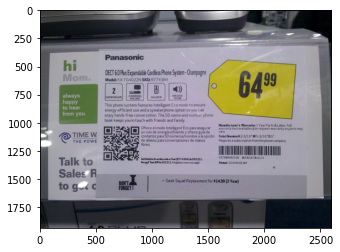

In [ ]:
plt.imshow(dataset[0][0])

Vamos ver alguns exemplos de imagens no nosso dataset com seus respectivos retângulos de marcação de QR Codes:

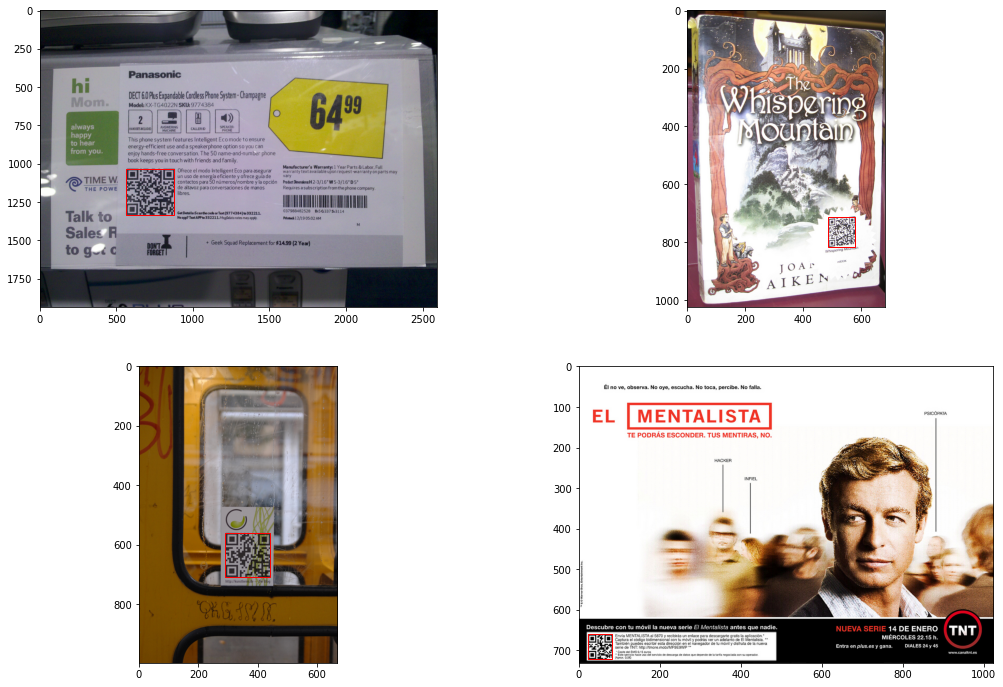

In [ ]:
def display_images(dataset, rows, columns, num_imgs, starting_index=0):
    # funcao para display de imagens com caixas de marcação dos qr codes
    fig, axs = plt.subplots(rows, columns, figsize=(18,12))
    for row in range(rows):
        for column in range(columns):
            index = row*rows + column
            axs[row][column].imshow(dataset[index][0])
            for rect in dataset[index + starting_index][1]:
                length, height = rect[1][0] - rect[0][0], rect[1][1] - rect[0][1]
                rect_draw = patches.Rectangle(rect[0], length, height, linewidth=1, edgecolor='r', facecolor='none')
                axs[row][column].add_patch(rect_draw)
plt.show()

num_imgs = 4
rows = 2
columns = 2
display_images(dataset, rows, columns, num_imgs)

Acho que seria legal a gente também dar uma olhada em algumas imagens com mais de um QR Code. Vamos criar um dataset pra ver essas imagens:

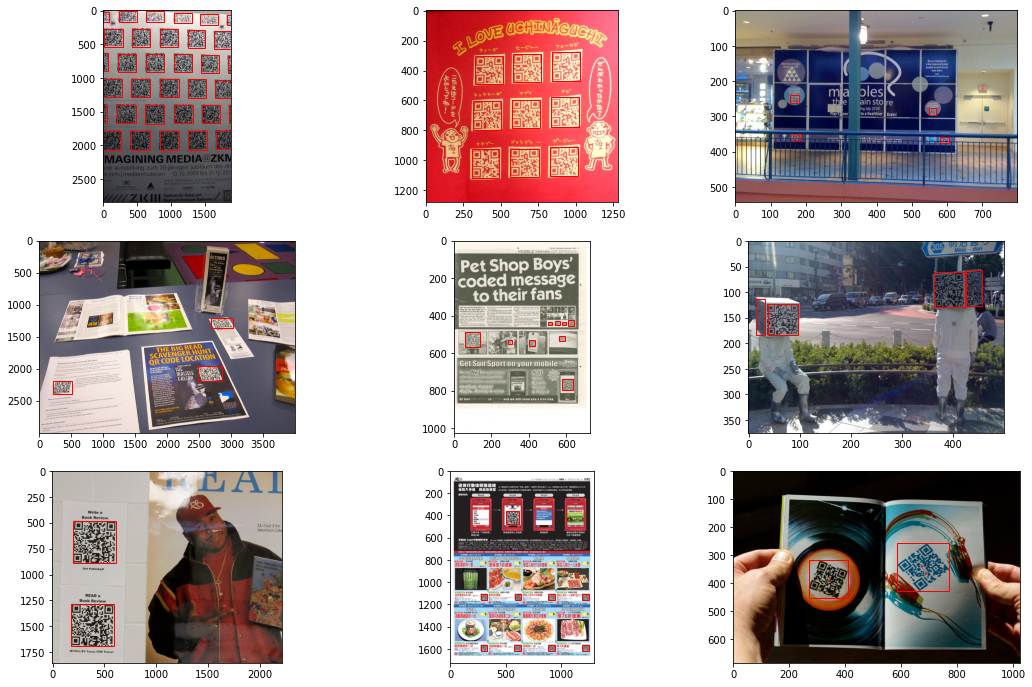

In [ ]:
data_multiple_qr = [data for data in dataset if len(data[1]) > 1]   # criando nossos dados com compreensao de listas

display_images(data_multiple_qr, 3, 3, 9)

# Adaptações do Dataset para alimentar YOLOv5

Primeiramente, precisamos adaptar o Dataset para os padrões do YOLOv5:

- [x_center, y_center, width, height]

Com valores normalizados. Cada imagem terá um .csv distinto.

Utilizando a função criada anteriormente, temos um dicionário em que cada key é o id de uma imagem e o value associado à essa key é uma lista de dicts. Isto é, cada dict nessa lista possuirá os campos:
- [id : [[x_center: val, y_center: val, width: val, height: val]]]




In [ ]:
!for f in /content/drive/Shareddrives/ML+Vision/projeto\ QR\ Code/qr_codes/labels/*; do cat "$f"; echo -e "\n\n"; done

In [ ]:
def formata_dados_yolo(lista: list):
  for inst in lista:
    csv = f"/content/drive/Shareddrives/ML+Vision/projeto QR Code/qr_codes/qr_codes_{inst}.csv"
    out_path=f"/content/drive/Shareddrives/ML+Vision/projeto QR Code/qr_codes/dataset/{inst}/labels"
    data = cria_dict(csv)
    save_to_txt(data, out_path)
    for image in data.keys():
      from_p=f"/content/drive/Shareddrives/ML+Vision/projeto QR Code/qr_codes/images/{image}.jpg"
      to_p=f"/content/drive/Shareddrives/ML+Vision/projeto QR Code/qr_codes/dataset/{inst}/images/{image}.jpg"
      os.popen(f'cp "{from_p}" "{to_p}"')


In [ ]:
formata_dados_yolo(['train', 'test', 'valid'])

962it [00:00, 5802.69it/s]
158it [00:00, 4535.81it/s]
143it [00:00, 4092.65it/s]


The dataset is structured in the following manner:

```
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```